In [1]:
# credits for transformer backbone with multi-query attention: https://github.com/M-e-r-c-u-r-y/
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler  #mixed prec
from torch_snippets import *
from torchtext.vocab import Vocab
from torchsummary import summary
import torchtext
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import subprocess as sub
from icecream import ic
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize, AffineTransform, warp
from math import ceil
from copy import deepcopy
from scipy import spatial
import random
import math
import time
import csv
from pathlib import Path
import functools as fts
import warnings
from collections import Counter, deque
from typing import Union, List

[07/17/21 09:28:00] WARNING  Skipping cv2 import                        ]8;id=1626514080.6579294-116392;file:///opt/conda/lib/python3.8/site-packages/torch_snippets/loader.py\loader.py]8;;\:<module>:48

[07/17/21 09:28:01] WARNING  sklearn is not found. Skipping relevant  ]8;id=1626514081.88263-748117;file:///opt/conda/lib/python3.8/site-packages/torch_snippets/__init__.py\__init__.py]8;;\:<module>:13
                             imports from submodule `sklegos`                                
                             Exception: No module named 'sklego'

In [2]:
ic.configureOutput(includeContext=True)

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
rng = np.random.default_rng(SEED)

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
savename = 'pic2sec_pytorch_vit_30k_glove_convemb'
this_dir = os.getcwd()
data_dir = os.path.join(this_dir, '30k', 'flickr30k_images')
pic_dir = os.path.join(this_dir, '30k', 'flickr30k_images', 'flickr30k_images')
ckp_dir = os.path.join(this_dir, 'ckp')
df_source = pd.read_csv(os.path.join(data_dir, 'results.csv'), sep='|')  # .sample(frac=0.1)
df_source.dropna(inplace=True)
df_source = df_source[df_source['caption'].str.len()>10]  # I consider shorter sentences as an impaired.

In [5]:
df_source

,image,comment_number,caption
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
...,...,...,...
158910,998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ov...
158911,998845445.jpg,1,"A young man hanging over the side of a boat ,..."
158912,998845445.jpg,2,A man is leaning off of the side of a blue an...
158913,998845445.jpg,3,"A man riding a small boat in a harbor , with ..."


In [6]:
class Lang:
    'Class acts as a metadata container'

    def __init__(self, name: str):
        self.name = name
        self.words = {'<sos>', '<eos>'}
        self.word2count = {'<sos>': 0, '<eos>': 0,}
        self.maxlen = 0
        self.stats = np.array([], dtype=np.int_)  # sentence length stats

    def add_sentence(self, sentence: list):
        self.stats = np.append(self.stats,
                               len(sentence))
        if len(sentence) > self.maxlen:
            self.maxlen = len(sentence) 
        for word in sentence:
            self.add_word(word)
        self.word2count['<sos>'] += 1
        self.word2count['<eos>'] += 1

    def add_word(self, word: str):
        if word not in self.words:
            self.words.add(word)
            self.word2count[word] = 1
        else:
            self.word2count[word] += 1

    def plt_hist(self, show=True):
        plot = plt.hist(self.stats, bins='fd')
        if show:
            plt.show()
        else:
            return plot
    
    def n_words(self):
        return len(self.words) - 2 # without <sos> <eos>


# to trzeba dokończyć

class Tokenizer:
    'Class for handling text<->indexes operations'
    
    def __init__(self, voc: torchtext.vocab.Vocab=None,
                 tokenizer='basic_english',
                 tok_lang='en'):
        self.voc = voc
        self.tokenizer = torchtext.data.utils.get_tokenizer(
            tokenizer, tok_lang)
        self.unk = 0  # <unk> counter
        self.unk_set = set()

    def to_tokens(self, sentence: str):
        return self.tokenizer(sentence)
    
    def to_sentence(self, indexes: list) -> str:
        'Creates sentence from indexes. REMOVES SPECIAL TOKENS'
        assert voc is not None, 'Method unavailable for dummy tokenizers'
        
        sentence = ' '.join(
            [self.voc.itos[idx] for idx in indexes if voc.itos[idx] not in ['<sos>', '<eos>', '<pad>']])
            
        return sentence
    
    @fts.singledispatchmethod
    def to_indexes(self, sentence, maxlen) -> list:
        'Creates indexes from words. ADS SPECIAL TOKENS. Accepts list or str.'

        raise NotImplementedError('Sentence must be a list or a str type')

    @to_indexes.register  # handling sentence as str type (untokenized)
    def _(self, sentence: str, maxlen: int):
        assert voc is not None, 'Method unavailable for dummy tokenizers'

        tokenized = deque(self.to_tokens(sentence))
        tokenized.appendleft('<sos>')
        tokenized.append('<eos>')
        # padding takes into account length increase by special tokens
        tokenized.extend(['<pad>' for _ in range(maxlen + 2 - len(tokenized))])

        indexes = [self.voc.stoi.get(wrd, self.voc.stoi['<unk>']) for wrd in tokenized]
        
        unk_count = indexes.count(self.voc.stoi['<unk>'])
        if unk_count:
            self.unk += unk_count
            self.unk_set.add(tokenized[indexes.index(self.voc.stoi['<unk>'])])

        return indexes

    @to_indexes.register  # handling sentence as listy type (tokenized)
    def _(self, sentence: list, maxlen: int):
        assert voc is not None, 'Method unavailable for dummy tokenizers'
        
        sentence = map(lambda x: x.casefold(), sentence)
        
        sentence = deque(sentence)
        sentence.appendleft('<sos>')
        sentence.append('<eos>')
        # padding takes into account length increase by special tokens
        sentence.extend(['<pad>' for _ in range(maxlen + 2 - len(sentence))])

        indexes = [self.voc.stoi.get(wrd, self.voc.stoi['<unk>']) for wrd in sentence]
        
        unk_count = indexes.count(self.voc.stoi['<unk>'])
        if unk_count:
            self.unk += unk_count
            self.unk_set.add(sentence[indexes.index(self.voc.stoi['<unk>'])])

        return indexes

@fts.singledispatch
def trimm_len(indexes, lang: Lang, voc: torchtext.vocab.Vocab, max_len_allowed: int):
    'Trimms list of indexes to the length specified'
    
    raise NotImplementedError('Sentence must be a list or a str type')

@trimm_len.register
def _(indexes: list, lang: Lang, voc: torchtext.vocab.Vocab, max_len_allowed: int):
    warnings.warn(f'You are trimming the sentence down to length={max_len_allowed}!')
    
    _indexes = indexes[:max_len_allowed]
    
    if _indexes[-1] not in [voc.stoi['<pad>'], voc.stoi['<eos>']]:
        _indexes.append(voc.stoi['<eos>'])
    else:
        _indexes.append(voc.stoi['<pad>'])

    return _indexes

@trimm_len.register
def _(indexes: list, lang: Lang, voc: type(None), max_len_allowed: int):
    warnings.warn(f'You are trimming the sentence down to length={max_len_allowed}!')
    
    _indexes = indexes[:max_len_allowed]
    
    return _indexes

In [7]:
# checks :)

txt = 'i like trains'
txt2 = 'DuPa Cycki'
lang = Lang('test')
tok = Tokenizer() # dummy tokenizer
lang.add_sentence(tok.to_tokens(txt))
lang.add_sentence(tok.to_tokens(txt2))
fq = Counter(lang.word2count)
voc = Vocab(fq, min_freq=1, specials=['<sos>', '<eos>', '<pad>', '<unk>'])
toke = Tokenizer(voc)
toke.to_indexes(txt, lang.maxlen)

[0, 6, 7, 8, 1]

In [8]:
voc.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f9648f876d0>>,
            {'<sos>': 0,
             '<eos>': 1,
             '<pad>': 2,
             '<unk>': 3,
             'cycki': 4,
             'dupa': 5,
             'i': 6,
             'like': 7,
             'trains': 8})

In [9]:
@fts.singledispatch
def txt_processor(sentence, lang: Lang) -> list:
    'Preprosess sentence and load data to Lang class instance'
    
    raise NotImplementedError('Sentence must be a list or a str type')

@txt_processor.register
def _(sentence: str, lang: Lang) -> list:
    _sentence = Tokenizer().to_tokens(sentence)
    lang.add_sentence(_sentence)
    
    return _sentence

@txt_processor.register
def _(sentence: list, lang: Lang) -> list:
    _sentence = [wrd.casefold() for wrd in sentence]
    lang.add_sentence(_sentence)
    
    return _sentence
        
lang_data = Lang('metadata_for_flickr_captions')   
captions = df_source.apply(lambda x: txt_processor(x['caption'], lang_data), axis=1)

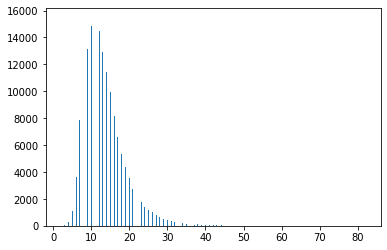

In [10]:
lang_data.plt_hist()

In [11]:
# as we can see, we have quite long tail on the right
# computation will be faster if we trimm out e.g. top 5 % the longest sentences
max_len_allowed = int(np.percentile(lang_data.stats, 90, interpolation='nearest'))
captions_shorter = captions.apply(lambda x: trimm_len(x, lang_data, None, max_len_allowed))
df_source_shorter = df_source.copy()
df_source_shorter['caption'] = captions_shorter

<ipython-input-6-34ea7a530965>:132: UserWarning: You are trimming the sentence down to length=20!
  warnings.warn(f'You are trimming the sentence down to length={max_len_allowed}!')


In [12]:
lang_data_shorter = Lang('metadata_for_flickr_captions_shorter')   
_ = df_source_shorter.apply(lambda x: txt_processor(x['caption'], lang_data_shorter), axis=1)
frequency = Counter(lang_data_shorter.word2count)
vocabulary = Vocab(frequency, min_freq=10, vectors='glove.6B.200d',
                   specials=['<sos>', '<eos>', '<pad>', '<unk>']) # , unk_init=torch.Tensor.normal_

In [13]:
tokenizer = Tokenizer(vocabulary)
tokenized_captions = captions_shorter.apply(lambda x: tokenizer.to_indexes(x, lang_data_shorter.maxlen))

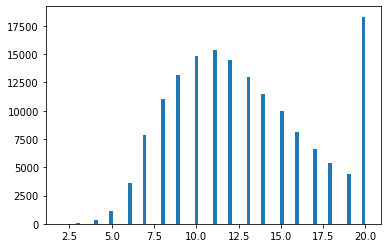

In [14]:
lang_data_shorter.plt_hist()

In [15]:
# percentage of <unk>
(tokenizer.unk/sum(lang_data_shorter.word2count.values())) * 100

1.4681346744971693

In [16]:
df_tokenized = df_source_shorter.copy()
df_tokenized['caption'] = tokenized_captions

In [17]:
def set_sampler(s: set):
    elem = random.sample(s, 1)[0]
    s.remove(elem)
    
    return elem

pic_set = set(df_tokenized['image'])
unique_pic_val = [set_sampler(pic_set) for _ in range((256*8)//5)]
unique_pic_test = [set_sampler(pic_set) for _ in range((256*16)//5)]
df_val = df_tokenized[df_tokenized['image'].isin(unique_pic_val)]
df_test = df_tokenized[df_tokenized['image'].isin(unique_pic_test)]
df_train = df_tokenized.drop(df_val.index).drop(df_test.index)

In [18]:
del df_source
del df_source_shorter
del df_tokenized

In [20]:
@fts.singledispatch
def find_closest(wrd, vocab: torchtext.vocab.Vocab, n: int) -> list:
    'finding n closest words as indexes'
    
    raise NotImplementedError(f'wrd must be an int or a str type. Is {type(wrd)}')

@find_closest.register
def _(wrd: int, vocab: torchtext.vocab.Vocab, n: int) -> list:
    'finding n closest words as indexes'
    vec = vocab.vectors
    wds = sorted(vocab.stoi.values(), key=lambda x: spatial.distance.euclidean(vec[wrd], vec[x]))[1:n+1]
    wds_str = [vocab.itos[i] for i in wds]
    
    if wds[0] in [0, 1, 2, 3]:
        warnings.warn('This word probably does not exist in the embedding!')
    
    return wds, wds_str, vocab.itos[wrd]

@find_closest.register
def _(wrd: str, vocab: torchtext.vocab.Vocab, n: int) -> list:
    'finding n closest words as indexes'
    vec = vocab.vectors
    idx = vocab.stoi[wrd]
    wds = sorted(vocab.stoi.values(), key=lambda x: spatial.distance.euclidean(vec[idx], vec[x]))[1:n+1]
    wds_str = [vocab.itos[i] for i in wds]
    
    if wds[0] in [0, 1, 2, 3]:
        warnings.warn('This word probably does not exist in the embedding!')
    
    return wds, wds_str, wrd

In [23]:
# defining dataset loader


class FlickrData(Dataset):
    def __init__(self,
                 img_names: pd.Series,
                 sequence_in: pd.Series,
                 pic_folder: str,
                 channels: int,
                 rotation=0,
                 shear=0,
                 translation=0,
                 seed=0):
        '''
        rotation in degrees
        shear in radians
        translation as tuple (x, y)
        '''
        super().__init__()
        self.x1 = img_names.to_list()
        self.x2 = np.array(
            [np.array(item, dtype=np.int_) for _, item in sequence_in.iteritems()],
            dtype=np.int_)
        self.pic_folder = pic_folder
        self.channels = channels
        self.rotation = rotation
        self.shear = shear
        self.translation = translation
        self.samples = len(self.x1)
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.rng = np.random.default_rng(seed)

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        x1 = self.preprocess_img(self.x1[idx])
        x2 = torch.tensor(self.x2[idx]).to(device).long()

        return x1, x2

    def preprocess_img(self, img_name):
        img_path = os.path.join(self.pic_folder, img_name)
        transormation = AffineTransform(
            rotation=self.rng.normal(0, self.rotation),
            shear=self.rng.normal(0, self.shear),
            translation=(self.rng.normal(0, self.translation),
                         self.rng.normal(0, self.translation)))
        
        img = np.float32(imread(img_path))
        if self.rng.uniform() > 0.5:
            img = np.flip(img, 1)
        img = resize(warp(img / 255, transormation),
                   (224, 224, self.channels))
        img = torch.tensor(img).permute(2, 0, 1)
        img = self.normalize(img)
        
        return img.to(device).float()

In [24]:
class SepConv2d(nn.Module):
    'Depthwise separable version of 2D convolution'
    def __init__(self,
                 chan_in: int,
                 chan_out: int,
                 kernel_size: int,
                 stride: int,
                 padding: Union[int, tuple, str]):
        super().__init__()
        self.depth = nn.Conv2d(chan_in, chan_in, kernel_size=kernel_size,
                               groups=chan_in, stride=stride, padding=padding)
        self.point = nn.Conv2d(chan_in, chan_out, kernel_size=1,
                               stride=1, padding=0)
        
    def forward(self, x: torch.Tensor):
        x = self.depth(x)
        x = self.point(x)

        return x

In [25]:
# early convolutions help transformer see better https://arxiv.org/pdf/2106.14881.pdf
class PatchEmb(nn.Module):
    def __init__(self, pic_dims, hid_dim, dropout, device):
        assert pic_dims[1] == pic_dims[2], 'Reshape a picture to even (h w) dims'
        assert all([dim % 16 == 0 for dim in pic_dims[1:]]), 'Reshape a picture to dims divisable by 16'
        super().__init__()
        self.hid_dim = hid_dim
        self.dropout = nn.Dropout(dropout)
        self.conv = nn.Sequential(SepConv2d(pic_dims[0], pic_dims[0], kernel_size=3,
                                    stride=1, padding=1), nn.BatchNorm2d(pic_dims[0]), nn.ReLU(),
                                  SepConv2d(pic_dims[0], 8, kernel_size=3,
                                    stride=2, padding=1), nn.BatchNorm2d(8), nn.ReLU(),
                                  SepConv2d(8, 16, kernel_size=3,
                                    stride=2, padding=1), nn.BatchNorm2d(16), nn.ReLU(),
                                  SepConv2d(16, 32, kernel_size=3,
                                    stride=2, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
                                  SepConv2d(32, 64, kernel_size=3,
                                    stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU())
        self.emb = nn.Sequential(SepConv2d(64, hid_dim, kernel_size=1,
                                    stride=1, padding=0), nn.Flatten(-2, -1))
        self.synth_len = (pic_dims[1]//16)**2 + 1
        self.pos_embedding = nn.Embedding(self.synth_len, hid_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, hid_dim))
        self.device = device
        
    def forward(self, pic):
        
        pos = torch.arange(0, self.synth_len
                          ).unsqueeze(0).repeat(pic.shape[0], 1).to(self.device)
        cls_tok = self.cls_token.repeat(pic.shape[0], 1, 1).to(self.device)
        x = self.conv(pic)
        x = self.emb(x).permute(0, 2, 1)
        x = torch.cat([cls_tok, x], dim=1)
        x += self.pos_embedding(pos)
        
        return x
        

In [26]:
class PicEncoder(nn.Module):
    def __init__(self,
                 pic_dims,
                 n_layers,
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        self.embedder = PatchEmb(pic_dims, hid_dim, dropout, device)
        self.transformer = nn.ModuleList([EncoderLayer(hid_dim, 
                                                       n_heads, 
                                                       pf_dim, 
                                                       dropout, 
                                                       device) for _ in range(n_layers)])
        
    def forward(self, x):
        
        x = self.embedder(x)
        
        for layer in self.transformer:
            x = layer(x)
            
        return x

In [27]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.layer_norm1 = nn.LayerNorm(hid_dim)
        self.layer_norm2 = nn.LayerNorm(hid_dim)
        self.self_attention = MultiQueryAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                       pf_dim, 
                                                                       dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [batch size, src len, hid dim]
                
        #self attention
        _src, _ = self.self_attention(src, src, src)
        
        #dropout, residual connection and layer norm
        
        src = self.layer_norm1(src + self.dropout(_src))

        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.layer_norm2(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [28]:
class MultiQueryAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads,  dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = self.hid_dim // self.n_heads

        self.Pq = nn.Linear(self.hid_dim, self.hid_dim)
        self.Pk = nn.Linear(self.hid_dim, self.head_dim)
        self.Pv = nn.Linear(self.hid_dim, self.head_dim)
        self.Po = nn.Linear(self.hid_dim, self.hid_dim)
        
        self.dropout = nn.Dropout(dropout)

        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        query_len = query.shape[1]
        key_len = key.shape[1]
        value_len = value.shape[1]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        Qbank = self.Pq(query).view(batch_size, -1, self.n_heads, self.head_dim)
        Kbank = self.Pk(key).view(batch_size, -1, self.head_dim)
        Vbank = self.Pv(value).view(batch_size, -1, self.head_dim)
        
        #Qbank = [batch size, query len, n heads, head dim]
        #Kbank = [batch size, key len, head dim]
        #Vbank = [batch size, value len, head dim ]

        energy = torch.einsum('bmhd,bnd->bhmn',Qbank,Kbank) / self.scale

        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        attention = F.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
        o = torch.einsum('bhmn,bnv->bmhv',self.dropout(attention), Vbank).contiguous()
        o = o.view(batch_size,query_len,-1)

        y = self.Po(o)
        
        #y = [batch size, query len, hid dim]
        
        return y, attention

In [29]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(F.gelu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [30]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 embedding,
                 dropout,
                 device,
                 max_length,
                 pad_idx):
        super().__init__()

        self.device = device

        # pretrained embedding
        self.tok_embedding = nn.Parameter(embedding, requires_grad=False)
        # self.tok_embedding = nn.Embedding(output_dim, hid_dim, padding_idx=pad_idx)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([
            DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
            for _ in range(n_layers)
        ])

        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask):  # src_mask

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size,
                                                           1).to(self.device)

        #pos = [batch size, trg len]
        trg = self.dropout((self.tok_embedding[trg]  # accesing non nn embedding should be with []
                            * self.scale) + self.pos_embedding(pos))

        #trg = [batch size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask)  # src_mask

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        output = self.fc_out(trg)

        #output = [batch size, trg len, output dim]
        
        return output, attention

In [31]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()

        self.layer_norm1 = nn.LayerNorm(hid_dim)
        self.layer_norm2 = nn.LayerNorm(hid_dim)
        self.layer_norm3 = nn.LayerNorm(hid_dim)
        self.self_attention = MultiQueryAttentionLayer(
            hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiQueryAttentionLayer(
            hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(
            hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask):   # src_mask

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        

        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        #dropout, residual connection and layer norm
        trg = self.layer_norm1(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]

        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src)  # src_mask removed due to encoder nature

        #dropout, residual connection and layer norm
        trg = self.layer_norm2(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]

        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        #dropout, residual and layer norm
        trg = self.layer_norm3(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        return trg, attention

In [32]:
class Pic2Seq(nn.Module):
    def __init__(self, encoder, decoder, trg_pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_trg_mask(self, trg):
        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(3)

        #trg_pad_mask = [batch size, 1, trg len, 1]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(
            torch.ones((trg_len, trg_len), device=self.device)).bool()

        #trg_sub_mask = [trg len, trg len]

        trg_mask = (trg_pad_mask & trg_sub_mask)

        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src1 = [batch_size, channels, dimy, dimx]
        #src2 = [batch size, src len]
        #trg = [batch size, trg len]
        
        # src_mask = self.make_src_mask(src2)
        # src_mask = torch.ones(enc_src.shape[:-1])  # just a filler mask
        trg_mask = self.make_trg_mask(trg)
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src)

        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask) 

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

In [33]:
OUTPUT_DIM = len(vocabulary.stoi.keys())
HID_DIM = 200 # 300
PIC_DIMS = (3, 224, 224)
ENC_LAYERS = 7 # 11   # 5 convolutions in patch embedding does some work
DEC_LAYERS = 8 # 12
HEADS = 5
PF_DIM = 512  # if > HID_DIM FF layer behaves as MLP, if < HID_DIM FF layer behaves as AE
# picture augumentation and many captions for one picture have regularizing effect also
ENC_DROPOUT = 0.2  
DEC_DROPOUT = 0.1
MAXLEN = len(tokenized_captions.iloc[0])
PAD_IDX = vocabulary.stoi['<pad>']
BATCH_SIZE = 128

enc = PicEncoder(PIC_DIMS,
              ENC_LAYERS,
              HID_DIM, 
              HEADS, 
              PF_DIM,
              ENC_DROPOUT,
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              HEADS, 
              PF_DIM, 
              vocabulary.vectors.to(device).float(),
              DEC_DROPOUT, 
              device,
              MAXLEN,
              PAD_IDX)

In [34]:
train_data = FlickrData(img_names=df_train.loc[:, 'image'],
                        sequence_in=df_train.loc[:, 'caption'],
                        pic_folder=pic_dir,
                        channels=3,
                        rotation=np.deg2rad(15),
                        shear=np.deg2rad(15),
                        translation=15,
                        seed=SEED)

val_data = FlickrData(img_names=df_val.loc[:, 'image'],
                      sequence_in=df_val.loc[:, 'caption'],
                      pic_folder=pic_dir,
                      channels=3,
                      seed=SEED)

test_data = FlickrData(img_names=df_test.loc[:, 'image'],
                      sequence_in=df_test.loc[:, 'caption'],
                      pic_folder=pic_dir,
                      channels=3,
                      seed=SEED)
trainflow = DataLoader(train_data, BATCH_SIZE, shuffle=True, num_workers=0)
valflow = DataLoader(val_data, BATCH_SIZE, shuffle=False, num_workers=0)
testflow = DataLoader(test_data, 1, shuffle=False, num_workers=0)

In [35]:
print(f'Train batches: {len(trainflow)}. Val batches: {len(valflow)}. Test batches: {len(testflow)}')

Train batches: 1194. Val batches: 16. Test batches: 4095

In [36]:
torch.cuda.empty_cache()
model = Pic2Seq(enc, dec, PAD_IDX, device).to(device)

In [37]:
# Model summary
pic_in = torch.randn(1, 3, 224, 224).float()
seq_in = torch.randn(1, MAXLEN).long()
summary(model, pic_in, seq_in)

Layer (type:depth-idx)                                       Output Shape              Param #
├─PicEncoder: 1-1                                            [-1, 197, 200]            --
|    └─PatchEmb: 2-1                                         [-1, 197, 200]            --
|    |    └─Sequential: 3-1                                  [-1, 64, 14, 14]          3,710
|    |    └─Sequential: 3-2                                  [-1, 200, 196]            13,128
|    |    └─Embedding: 3-3                                   [-1, 197, 200]            39,400
|    └─ModuleList: 2                                         []                        --
|    |    └─EncoderLayer: 3-4                                [-1, 197, 200]            302,792
|    |    └─EncoderLayer: 3-5                                [-1, 197, 200]            302,792
|    |    └─EncoderLayer: 3-6                                [-1, 197, 200]            302,792
|    |    └─EncoderLayer: 3-7                                [-1, 197

Layer (type:depth-idx)                                       Output Shape              Param #
├─PicEncoder: 1-1                                            [-1, 197, 200]            --
|    └─PatchEmb: 2-1                                         [-1, 197, 200]            --
|    |    └─Sequential: 3-1                                  [-1, 64, 14, 14]          3,710
|    |    └─Sequential: 3-2                                  [-1, 200, 196]            13,128
|    |    └─Embedding: 3-3                                   [-1, 197, 200]            39,400
|    └─ModuleList: 2                                         []                        --
|    |    └─EncoderLayer: 3-4                                [-1, 197, 200]            302,792
|    |    └─EncoderLayer: 3-5                                [-1, 197, 200]            302,792
|    |    └─EncoderLayer: 3-6                                [-1, 197, 200]            302,792
|    |    └─EncoderLayer: 3-7                                [-1, 197

In [38]:
torch.cuda.empty_cache()

In [39]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [40]:
'''MAX_RATE = 0.01
MIN_RATE = 0.00001'''

MAX_RATE = 0.2
MIN_RATE = 0.00001

# papers as https://arxiv.org/pdf/2004.08249.pdf claims SGD is bad at transformers
# BUT I am using scheduler, so it is different situation
# SGD with schedule is far more computation efficient than eg. Adam
# additionaly, low MIN_RATE acts as warmup stage, and later may help with local minima
optimizer = torch.optim.SGD(model.parameters(), lr=MIN_RATE)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,
                                              base_lr=MIN_RATE,
                                              max_lr=MAX_RATE,
                                              mode='triangular',
                                              step_size_up=len(trainflow) * 4)

In [42]:
criterion = nn.CrossEntropyLoss(ignore_index = vocabulary.stoi['<pad>']) # ignore PAD index

In [43]:
ckp_log = os.path.join(ckp_dir, f'last_ckp_{savename}.csv')

if not os.path.exists(ckp_log):
    Path(ckp_log).touch()
    with open(ckp_log, 'a') as file:
        line = ','
        file.write(line)

# last_cpk = pd.read_csv(ckp_log).iloc[-1, 0]

In [44]:
def train_batch(src, trg, model, opt, crit, scaler, scheduler):
    model.train()
    opt.zero_grad()
    with autocast():
        pred_seq, _ = model(src, trg) # model(src, trg[:,:-1])
        pad = np.array([vocabulary.stoi['<pad>']])
        pad = np.expand_dims(pad, axis=0)
        pad = np.repeat(pad, trg.shape[0], axis=0) # batch repeat
        pad = torch.LongTensor(pad).to(device)
        trg = torch.cat([trg, pad], dim=-1)
        trg = trg[:,1:].contiguous().view(-1)
        pred_seq = pred_seq.contiguous().view(-1, pred_seq.shape[-1])
        loss = crit(pred_seq, trg)
    scaler.scale(loss).backward()
    scaler.unscale_(opt)  # for clipping
    torch.nn.utils.clip_grad_value_(model.parameters(), 1.0)
    scaler.step(opt)
    scaler.update()
    scheduler.step()
    return loss, pred_seq

def val_batch(src, trg, model, crit):
    model.eval()
    with torch.no_grad():
        with autocast():
            pred_seq, _ = model(src, trg)
            pad = np.array([vocabulary.stoi['<pad>']])
            pad = np.expand_dims(pad, axis=0)
            pad = np.repeat(pad, trg.shape[0], axis=0) # batch repeat
            pad = torch.LongTensor(pad).to(device)
            trg = torch.cat([trg, pad], dim=-1)
            trg = trg[:,1:].contiguous().view(-1)
            pred_seq = pred_seq.contiguous().view(-1, pred_seq.shape[-1])
            loss = crit(pred_seq, trg)
    return loss, pred_seq

In [45]:
scaler = GradScaler()  # prevents gradient underflow in f16
model.apply(initialize_weights)

Pic2Seq(
  (encoder): PicEncoder(
    (embedder): PatchEmb(
      (dropout): Dropout(p=0.2, inplace=False)
      (conv): Sequential(
        (0): SepConv2d(
          (depth): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
          (point): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
        )
        (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): SepConv2d(
          (depth): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3)
          (point): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
        )
        (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): SepConv2d(
          (depth): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=8)
          (point): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine

In [ ]:
epochs = 32
logger = Report(epochs)
for epoch in range(epochs):
        
    N = len(trainflow)
    for ix, srctrg in enumerate(trainflow):
        src, trg = srctrg
        total_loss, pred_seq = train_batch(src, trg, model, optimizer,
                                           criterion, scaler, scheduler)
        logger.record(epoch + (ix + 1) / N, trn_loss=total_loss, end='\r')

    
    if epoch % 8 == 0:
        cpk = f'cpk_{savename}_{epoch}.tar'
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': total_loss
            }, os.path.join(ckp_dir, cpk))
                
        with open(os.path.join(ckp_dir, cpk), 'a') as file:
            line = [cpk, time.time()]
            writer = csv.writer(file, delimiter=' ')
            writer.writerow(line)
                
    N = len(valflow)
    for ix, srctrg in enumerate(valflow):
        src, trg = srctrg
        total_loss, pred_seq = val_batch(src, trg, model, criterion)
        logger.record(epoch + (ix + 1) / N, val_loss=total_loss, end='\r')
                
    logger.report_avgs(epoch+1)
                
logger.plot_epochs()

EPOCH: 1.000	trn_loss: 5.224	val_loss: 4.227	(4331.58s - 134278.95s remaining)
EPOCH: 2.000	trn_loss: 3.890	val_loss: 3.599	(8718.00s - 130770.04s remaining)
EPOCH: 3.000	trn_loss: 3.472	val_loss: 3.328	(13004.77s - 125712.81s remaining)
EPOCH: 4.000	trn_loss: 3.284	val_loss: 3.210	(17267.38s - 120871.66s remaining)
EPOCH: 5.000	trn_loss: 3.162	val_loss: 3.105	(21578.24s - 116522.47s remaining)
EPOCH: 6.000	trn_loss: 3.070	val_loss: 3.033	(25936.52s - 112391.59s remaining)
EPOCH: 7.000	trn_loss: 3.003	val_loss: 2.985	(30352.24s - 108400.85s remaining)
EPOCH: 8.000	trn_loss: 2.942	val_loss: 2.948	(34722.20s - 104166.61s remaining)
EPOCH: 9.000	trn_loss: 2.924	val_loss: 2.961	(38897.05s - 99403.57s remaining)
EPOCH: 10.000	trn_loss: 2.947	val_loss: 2.972	(43044.88s - 94698.73s remaining)
EPOCH: 11.000	trn_loss: 2.949	val_loss: 2.961	(47174.87s - 90061.11s remaining)
EPOCH: 12.000	trn_loss: 2.938	val_loss: 2.963	(51306.74s - 85511.24s remaining)
EPOCH: 13.000	trn_loss: 2.910	val_loss: 2.9

In [ ]:
N = len(testflow)
losses = []
seqs = []
for ix, srctrg in tqdm(enumerate(testflow)):
    src, trg = srctrg
    total_loss, pred_seq = val_batch(src, trg, model, criterion)
    losses.append(total_loss)
    seqs.append((trg.cpu().numpy(), pred_seq.cpu().numpy()))

In [ ]:
print(f'Avg loss: {sum(losses)/len(losses)}')

In [ ]:
checkpoint = torch.load(os.path.join(ckp_dir, 'cpk_pic2sec_pytorch_vit_8k_glove_convemb_10.tar'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
def infer_single(src, trg, model):
    src_tensor = src # torch.FloatTensor(src).unsqueeze(0).to(device)
    trg_tensor = torch.LongTensor(trg).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        with autocast():
            enc_src = model.encoder(src_tensor)
            trg_mask = model.make_trg_mask(trg_tensor)
            pred, _ = model.decoder(trg_tensor, enc_src, trg_mask)
            pred = nn.LogSoftmax(dim=2)(pred)
            pred_argsort = pred.argsort(2)
            pred_best = pred_argsort[:,-1, -1].item()
            pred_second_best = pred_argsort[:,-1, -2].item()
            score_best = pred[:, -1, pred_best].item()
            score_second_best = pred[:, -1, pred_second_best].item()
    
    # returns predicted indexes, suitable for simple beam search
    return (pred_best, score_best), (pred_second_best, score_second_best)
